In [1]:
#Use miniconda-analysis environment
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import co2_timeseries_tools as co2tt
from scipy import stats
from scipy import signal
from ctsm_py import utils
import pandas as pd

### Obs Data

In [2]:
path='/glade/work/dll/CTSM_py/notebooks/'
brw={'name':'Barrow', 'acronym': 'brw',  'lat': 71.3, 'lon':360-156.61, 'z': 11.0}
mlo={'name':'Mauna Loa', 'acronym': 'mlo', 'lat': 19.5, 'lon':360-155.6, 'z':3397.0}
alt={'name':'Alert', 'acronym': 'alt', 'lat': 82.5, 'lon':360-62.5, 'z':200.0}
azr={'name': 'Azores', 'acronym':'azr','lat':38.8, 'lon':360-27.4, 'z':19.0}
cba={'name': 'Cold Bay', 'acronym':'cba', 'lat':55.2, 'lon':360-162.7, 'z':21.3}
kum={'name':'Kumukahi', 'acronym':'kum', 'lat':19.7, 'lon':360-155.0, 'z':0.3}
ESRL=[brw, mlo, alt, azr, cba, kum]
lats=np.array([71.3,19.5,82.5,38.8,55.2,19.7])
lons=np.array([360-156.61,360-155.6,360-62.5,360-27.4,360-162.7,360-155.0])
#note that the 'lev' variable only goes from 0 to 1000, not sure how to translate from 'alt' to 'lev'
alt=np.array([11.0,3397.0,200.0,19.0,21.3,0.3])
cesm1levs=np.array([25,20,25,25,25,25])
cesm2levs=np.array([31,22,31,31,31,31])

In [3]:
minYear = 1981 # minimum year for an 'early' trend, used later for plotting

for site in ESRL:
#    print(site)
    filename=path+'co2_'+site['acronym']+'_surface-flask_1_ccgg_month.txt'
    #import glob
    #filename=glob.glob(partialname+ '*co2')
    with open(filename, 'r') as fid:
        first_line=fid.readline()
        nheader=first_line[-3:-1]
        nheader=np.int(np.float(nheader))
    data=np.loadtxt(filename, usecols=(1,2,3), skiprows=nheader)
    time=data[:,0]+data[:,1]/12
    co2=data[:,2]
    month=data[:,1]
    year=data[:,0]
    site['year']=year
    site['month']=month
    site['co2']=co2
    
    #for y in range(len(site['year'])):
    #    site['min'][y] = site['co2'].min()
    #    site['max'][y] = site['co2'].max()
        

### Problem 1
I would like to calculate max - min for each year but can't figure out how to loop over the years.
The code below calculates absolute min and max across all years

### Solution 1
Ideally, I'd do this with groupby, or assign 'name' as the index for year & CO2, but this isn't working as I'd expect

Instead I'll just create data arrays to hold output I'm expecting, and throw out years with < 12 month of data

/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: All-NaN slice encountered
  
/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: All-NaN slice encountered
  from ipykernel import kernelapp as app


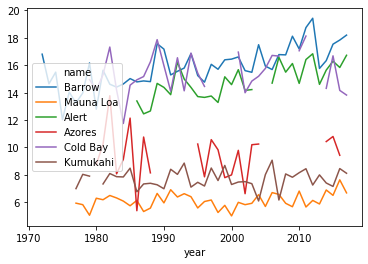

In [4]:
#convert to pandas dataframe
df = pd.DataFrame(ESRL,columns = ['name','year','co2'])

# create arrays to hold results (here xr)
# nobs will be used to count obs for each year & mask values when < 12
years = range(int(ESRL[0].get('year').min()),int(ESRL[0].get('year').max()))
minCO2 = xr.DataArray(np.nan, coords={'name': df.name, 'year':years}, dims=['name','year'])
maxCO2 = xr.DataArray(np.nan, coords={'name': df.name, 'year':years}, dims=['name','year'])
nobs   = xr.DataArray(np.nan, coords={'name': df.name, 'year':years}, dims=['name','year'])
# loop through each site & year
for i in range(len(df.name)):
    for j in range(len(years)):
        temp = np.where(ESRL[i]['year']==years[j],ESRL[i]['co2'],np.nan)
        maxCO2[i,j] = np.nanmax(temp) 
        minCO2[i,j] = np.nanmin(temp)
        nobs[i,j] = np.isnan(temp)[np.isnan(temp) == False].size

ampCO2 = maxCO2 - minCO2
ampCO2 = ampCO2.where(nobs==12)
ampCO2.plot.line(hue='name',x='year');
#print()

not sure how you want to handle missing data...?

### Model Data

In [6]:
simyrs             = "185001-201412"
var                = "CO2"

datadir            = "/glade/p/cesm/lmwg_dev/dll/"
subdir             = "/atm/proc/tseries/month_1/"
Mod1dir            = "CESM2_Coupled_NoCrop/"

sim                = "b.e21.BHIST_BPRP.f09_g17.CMIP6-esm-hist.001"
sim2               = "b40.20th.1deg.coup.001"

In [7]:
data1          = utils.time_set_mid(xr.open_dataset(datadir+Mod1dir+sim+".cam.h0."+var+"."+simyrs+".nc", decode_times=True), 'time')
data2          = utils.time_set_mid(xr.open_dataset(datadir+Mod1dir+sim2+".cam2.h0."+var+".185001-200512.nc", decode_times=True), 'time')

### Converting CO2 units to ppm

In [8]:
#conversion of CESM CO2 to ppm
convert = 10.0**6 * 28.966/44.0

In [9]:
%%time
## Are you intendings to swap CESM1 with data2 and CESM2 with data1?
CESM1ppm = data2.CO2.sel(time=slice('1950','2014')) * convert
CESM2ppm = data1.CO2.sel(time=slice('1950','2014')) * convert

CESM1ppm.attrs['units'] = 'ppm'
CESM2ppm.attrs['units'] = 'ppm'

CPU times: user 28.9 s, sys: 1min 14s, total: 1min 43s
Wall time: 6min 38s


### Selecting sites for comparison to observations

In [10]:
#initialize list using '[]' and dictionary using '{}'
CESM1points = {}
CESM2points = {}

#lat and lon are actual values to pull out, level refers to a specific index, not a value, so requires 'isel'
for x in range(6):
    CESM1pointloop = CESM1ppm.sel(lat=lats[x], lon=lons[x], method="nearest")
    CESM2pointloop = CESM2ppm.sel(lat=lats[x], lon=lons[x], method="nearest")
    CESM1pointloop = CESM1pointloop.isel(lev=cesm1levs[x])
    CESM2pointloop = CESM2pointloop.isel(lev=cesm2levs[x])
    CESM1points[x] = CESM1pointloop
    CESM2points[x] = CESM2pointloop

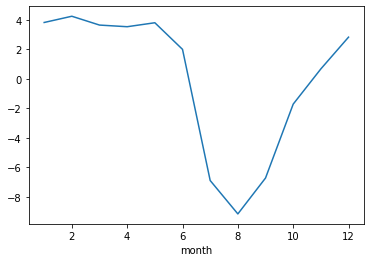

In [31]:
temp = CESM2points[0].sel(time=slice('1980','1985'))
#temp.plot()
xr.DataArray(signal.detrend(temp),coords={'time':temp.time}, dims='time').groupby("time.month").mean().plot();

### Calculating detrended annual cycle for early and late time periods

In [35]:
CESM1_ann_early = {}
CESM1_ann_late  = {}
CESM2_ann_early = {}
CESM2_ann_late  = {}
CESM1_ann_early_detrend = {}
CESM1_ann_late_detrend  = {}
CESM2_ann_early_detrend = {}
CESM2_ann_late_detrend  = {}

for site, data in CESM1points.items():
    CESM1late   = data.sel(time=slice('2000','2005'))
    CESM1early  = data.sel(time=slice('1980','1985'))
    CESM1_ann_late[site] = CESM1late.groupby("time.month").mean()
    CESM1_ann_early[site] = CESM1early.groupby("time.month").mean()
    CESM1_ann_early_detrend[site] = xr.DataArray(signal.detrend(CESM1early),coords={'time':CESM1early.time}, dims='time').groupby("time.month").mean()
    CESM1_ann_late_detrend[site] = xr.DataArray(signal.detrend(CESM1late),coords={'time':CESM1late.time}, dims='time').groupby("time.month").mean()
print(CESM1_ann_early_detrend[1])
print(type(CESM1_ann_early_detrend))

for site, data in CESM2points.items():
    CESM2late   = data.sel(time=slice('2000','2005'))
    CESM2early  = data.sel(time=slice('1980','1985'))
    CESM2_ann_late[site] = CESM2late.groupby("time.month").mean()
    CESM2_ann_early[site] = CESM2early.groupby("time.month").mean()
    CESM2_ann_early_detrend[site] = xr.DataArray(signal.detrend(CESM2early),coords={'time':CESM2early.time}, dims='time').groupby("time.month").mean()
    CESM2_ann_late_detrend[site] = xr.DataArray(signal.detrend(CESM2late),coords={'time':CESM2late.time}, dims='time').groupby("time.month").mean()
print(CESM1_ann_early_detrend[1])

<xarray.DataArray (month: 12)>
array([-0.1302948 ,  0.05968221,  0.41840616,  1.3913981 ,  1.6893768 ,
        1.1833597 ,  0.22428894, -0.5228831 , -1.0049235 , -1.3764801 ,
       -1.3142395 , -0.6173757 ], dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
<class 'dict'>
<xarray.DataArray (month: 12)>
array([-0.1302948 ,  0.05968221,  0.41840616,  1.3913981 ,  1.6893768 ,
        1.1833597 ,  0.22428894, -0.5228831 , -1.0049235 , -1.3764801 ,
       -1.3142395 , -0.6173757 ], dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12


## Problem #2
### Detrended plot has oddly high late-season values
Bottom plot is detrended. Should I be using a different function? 

## solution
Above, I changed when you're taking the mean of the detrended data. Now the data are detrended, then the monthly averages are taken

### Absolute value plot

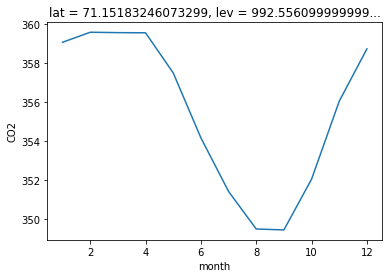

In [33]:
CESM1_ann_early[0].plot();

### Detrended Plot

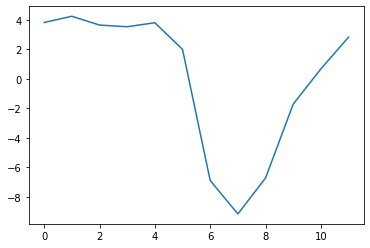

In [39]:
plt.plot(CESM1_ann_early_detrend[0])

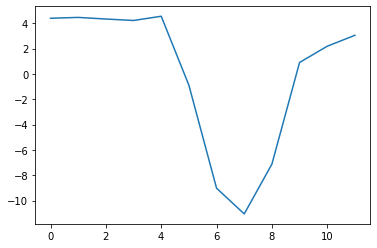

In [38]:
plt.plot(CESM1_ann_late_detrend[0]);